In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from functions import scalar_gaussian, vector_gaussian

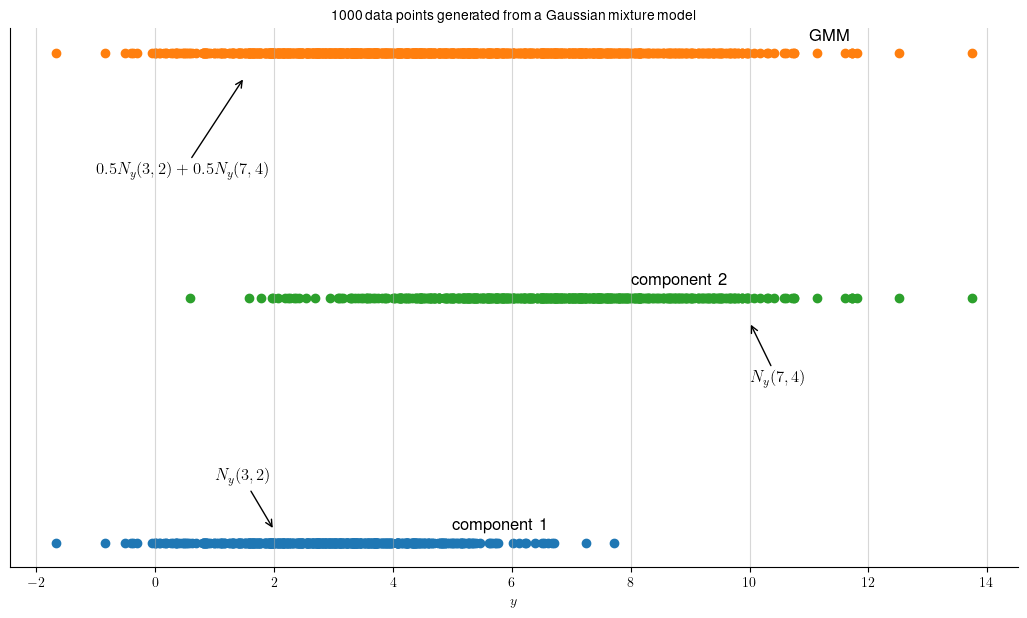

In [2]:
K = 2 #two Gaussian components
mu1 = 3 #setting the two means apart from each other
mu2 = 7
sigma1 = 2 #variances for the two Gaussian components
sigma2 = 4

pi_1 = 1/2
pi_2 = 1 - pi_1

N = 1000

X = np.zeros(N)
X1 = np.zeros(N) # vectors to save the samples of the two Gaussian components
X2 = np.zeros(N)
res1 = np.zeros(N)
res2 = np.zeros(N)

N1 = 0 # counts how many samples from first Gaussian component
N2 = 0 # counter for samples from second Gaussian component

for n in range(N):
    x = np.random.rand() #random number between 0 and 1
    if x <= pi_1: #generate data point from first Gaussian distribution
        k = 1
        x_bar = mu1
        SR = np.sqrt(sigma1)
        res1[N1] = k #save which component
        X1[N1] = x_bar + SR*np.random.randn() # generate Gaussian sample-
        X[n] = X1[N1] #save it
        N1 += 1
    else: #generate data point from second Gaussian distribution
        k = 2
        x_bar = mu2
        SR = np.sqrt(sigma2)
        res2[N2] = k #sabe which component
        X2[N2] = x_bar + SR*np.random.randn() # generate Gaussian sample
        X[n] = X2[N2]
        N2 += 1

#Plot data
YA = np.zeros(N1)
YB = 2*np.ones(N2)
YC = 4*np.ones(N)

XA = X1[:N1]
XB = X2[:N2]

#figure 1 (scatter plots)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,7
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(XA, YA, color="tab:blue")
ax.scatter(XB, YB, color="tab:green")
ax.scatter(X, YC, color="tab:orange")
ax.set_xlabel("$y$", fontsize=10)
ax.set_title("1000 data points generated from a Gaussian mixture model", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax.annotate("$0.5N_y(3, 2) + 0.5N_y(7, 4)$", xy=(1.5, 3.8), xytext=(-1, 3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
ax.annotate("$N_y(7, 4)$", xy=(10, 1.8), xytext=(10, 1.3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
ax.annotate("$N_y(3, 2)$", xy=(2, 0.1), xytext=(1, 0.5), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
ax.annotate("GMM", xy=(11, 4.1), fontsize=12, fontweight='bold')
ax.annotate("component 2", xy=(8, 2.1), fontsize=12, fontweight='bold')
ax.annotate("component 1", xy=(5, .1), fontsize=12, fontweight='bold')
plt.yticks([])

plt.show()

491 509 1000
3 7 2 4
6.73 2.967 3.938 2.094


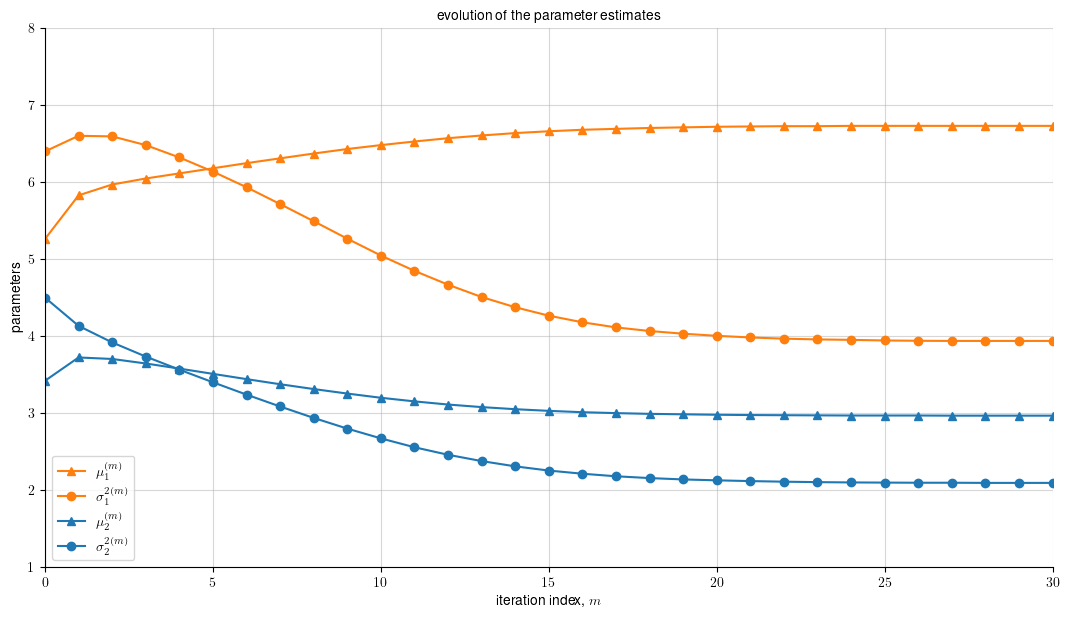

In [3]:
mu_hat = np.round(2*np.random.rand(2)).astype(np.float16) #initial condition for mean vector estimate
sigma_hat = (1 + np.round(2*np.random.rand(2))).astype(np.float16) #initial condition for variance estimates

mu_hat =np.array([1, 0]).astype(np.float16) #Forcing it to look like the book
sigma_hat = np.array([3, 3]).astype(np.float16) #Forcing it to look like the book

M = 50 # number of EM iterations
N_hat = np.zeros(2)
par = np.zeros((M, 4))
r_hat = np.zeros((K, N))

for m in range(M):
    #E-step
    for k in range(K): #iterarion over components
        for n in range(N): 
            y = X[n] #sample from the mixture distribution generated earlier
            a = scalar_gaussian(y, mu_hat[k], sigma_hat[k])
            d = scalar_gaussian(y, mu_hat[0], sigma_hat[0]) + scalar_gaussian(y, mu_hat[1], sigma_hat[1])
            r_hat[k, n] = a/d
        N_hat[k] = r_hat[k, :].sum()
    
    #M-step
    z1 = r_hat[0, :]@X.T
    z2 = r_hat[1, :]@X.T
    mu_hat[0] = z1/N_hat[0]
    mu_hat[1] = z2/N_hat[1]

    Xcen1 = X - mu_hat[0]*np.ones(N)
    Xcen2 = X - mu_hat[1]*np.ones(N)
    S1 = Xcen1**2
    S2 = Xcen2**2
    r1 = r_hat[0, :]@S1.T
    r2 = r_hat[1, :]@S2.T
    sigma_hat[0] = r1/N_hat[0]
    sigma_hat[1] = r2/N_hat[1]

    par[m, :] = np.array([
        mu_hat[0], mu_hat[1], sigma_hat[0], sigma_hat[1]
    ])

print(N1, N2, N)
print(mu1, mu2, sigma1, sigma2)
print(mu_hat[0], mu_hat[1], sigma_hat[0], sigma_hat[1])

#figure 2 (evolution of the EM estimates)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,7
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(np.arange(0, M, 1), par[:, 0], color="tab:orange", marker="^", label="$\mu_{1}^{(m)}$")
ax.plot(np.arange(0, M, 1), par[:, 2], color="tab:orange", marker="o", label="$\sigma_{1}^{2(m)}$")
ax.plot(np.arange(0, M, 1), par[:, 1], color="tab:blue", marker="^", label="$\mu_{2}^{(m)}$")
ax.plot(np.arange(0, M, 1), par[:, 3], color="tab:blue", marker="o", label="$\sigma_{2}^{2(m)}$")
ax.set_xlabel("iteration index, $m$", fontsize=10)
ax.set_ylabel("parameters", fontsize=10)
ax.set_title("evolution of the parameter estimates", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.yticks(np.arange(1, 9, 1))
plt.xticks(np.arange(0, 35, 5))
ax.set_xlim([0, 30])

plt.legend()

plt.show()

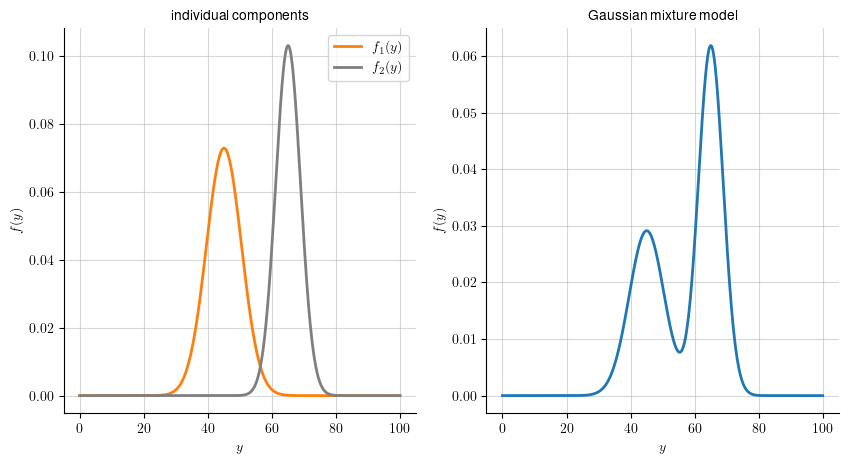

In [4]:
mu1 = 45
sigma1 = 30
mu2 = 65
sigma2 = 15
a1 = 1/(np.sqrt(2*np.pi*sigma1)) #scaling factors in Gaussian distributions
b1 = 0.5/sigma1
a2 = 1/(np.sqrt(2*np.pi*sigma2)) 
b2 = 0.5/sigma2
p = 0.4

x = np.arange(0, 100, 0.1)
f1 = a1*np.exp(-b1*(x-mu1)**2) # first Gaussian pdf
f2 = a2*np.exp(-b2*(x-mu2)**2) # second Gaussian pdf
f = p*f1 + (1-p)*f2 # mixture Gausssian

#figure 3 (Gaussian mixture model)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10,5
fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(x, f1, color="tab:orange", label="$f_{1}(y)$", linewidth=2)
ax.plot(x, f2, color="tab:gray", label="$f_{2}(y)$", linewidth=2)
ax.set_xlabel("$y$", fontsize=10)
ax.set_ylabel("$f(y)$", fontsize=10)
ax.set_title("individual components", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(122)
ax.plot(x, f, color="tab:blue", label="$f_{1}(y)$", linewidth=2)
ax.set_xlabel("$y$", fontsize=10)
ax.set_ylabel("$f(y)$", fontsize=10)
ax.set_title("Gaussian mixture model", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

plt.savefig("figs/fig-3.pdf", format="pdf", bbox_inches="tight")

plt.show()

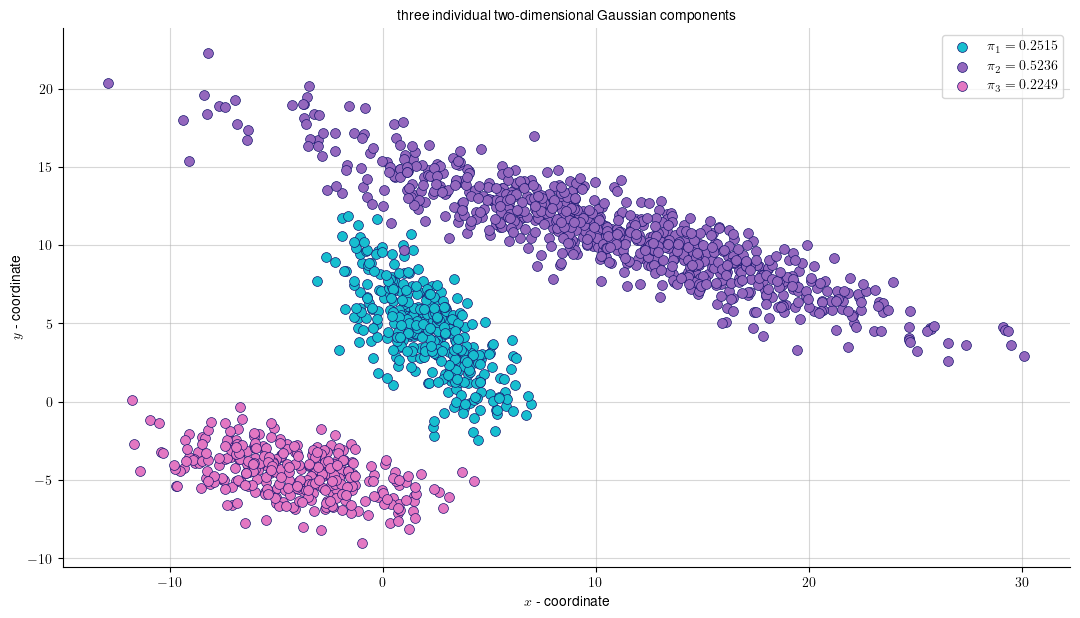

In [5]:
K = 3 # 3 Gaussian components
p = 2

mu1 = np.array([2.0187, 4.3124])
mu2 = np.array([10.5560, 10.7832])
mu3 = np.array([-4.3228, -4.5155])

R1 = np.array([
    [4, -4],
    [-4, 8]
])

R2 = np.array([
    [45, -18],
    [-18, 9]
])

R3 = np.array([
    [10, -2],
    [-2, 2]
])

pi_1 = 0.2515
pi_2 = 0.5236
pi_3 = 1-(pi_1+pi_2)

N = 1500
N1 = int(N*pi_1)
N2 = int(N*pi_2)
N3 = int(N*pi_3)

X1 = np.random.multivariate_normal(mean=mu1, cov=R1, size=N1)
X2 = np.random.multivariate_normal(mean=mu2, cov=R2, size=N2)
X3 = np.random.multivariate_normal(mean=mu3, cov=R3, size=N3)


#figure 2 (evolution of the EM estimates)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,7
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(X1[:, 0], X1[:, 1], label="$\pi_1 = 0.2515$", color="tab:cyan", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.scatter(X2[:, 0], X2[:, 1], label="$\pi_2 = 0.5236$", color="tab:purple", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.scatter(X3[:, 0], X3[:, 1], label="$\pi_3 = 0.2249$", color="tab:pink", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.set_xlabel("$x$ - coordinate", fontsize=10)
ax.set_ylabel("$y$ - coordinate", fontsize=10)
ax.set_title("three individual two-dimensional Gaussian components", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

plt.legend()

plt.show()



In [7]:
K = 3
p = 2

mu1 = [2, 3]
mu2 = [10, 10]
mu3 = [30, 14]

R1 = [[4, -4], [-4, 8]]
R2 = [[45, -18], [-18, 9]]
R1 = [[10, -2], [-2, 2]]

pi_1 = 1/3
pi_2 = 1/4
pi_3 = 5/12

N = 1500
N1 = int(N*pi_1)
N2 = int(N*pi_2)
N3 = int(N*pi_3)

X1 = np.random.multivariate_normal(mean=mu1, cov=R1, size=N1)
X2 = np.random.multivariate_normal(mean=mu2, cov=R2, size=N2)
X3 = np.random.multivariate_normal(mean=mu3, cov=R3, size=N3)

X = np.concatenate([X1, X2, X3])
np.random.shuffle(X) #concatenating samples from all 3 Gaussian components and shuffling its contents


# Running EM

mu_hat_1 = np.zeros((1,p))
mu_hat_2 = np.zeros((1,p))
mu_hat_3 = np.zeros((1,p))

mu_hat = [mu_hat_1, mu_hat_2, mu_hat_3]

R_hat_1 = np.eye(p) + np.round(np.random.rand(p, p)) #variance estimates
R_hat_2 = np.eye(p) + np.round(np.random.rand(p, p)) #variance estimates
R_hat_3 = np.eye(p) + np.round(np.random.rand(p, p)) #variance estimates

R_hat_1 = np.array([
    [1, 1], [1, 2]
])

R_hat_2 = np.array([
    [2, 1], [0, 2]
])

R_hat_3 = np.array([
    [2, 0], [1, 1]
])

R_hat = [R_hat_1, R_hat_2, R_hat_3]

pi_hat_1 = pi_hat_2 = pi_hat_3 = 1/3

pi_hat = [pi_hat_1, pi_hat_2, pi_hat_3]

r_hat = np.zeros((K, N))

M = 150 # number of iterations
N_hat = np.zeros(K)

for m in range(M):
    #E-step
    for k in range(K):
        mu_hat_k = mu_hat[k]
        R_hat_k = R_hat[k]
        pi_hat_k = pi_hat[k]

        for n in range(N):
            y = X[n]
            a = pi_hat_k*vector_gaussian(y, mu_hat_k, R_hat_k)
            d = pi_hat[0]*vector_gaussian(y, mu_hat[0], R_hat[0])
            d += pi_hat[1]*vector_gaussian(y, mu_hat[1], R_hat[1])
            d += pi_hat[2]*vector_gaussian(y, mu_hat[2], R_hat[2])
            r_hat[k, n] = a/d
        N_hat[k] = r_hat[k].sum()

    #M-step
    z1 = r_hat[0]@X
    z2 = r_hat[1]@X
    z3 = r_hat[2]@X

    mu_hat[0] = z1/N_hat[0]
    mu_hat[1] = z2/N_hat[1]
    mu_hat[2] = z3/N_hat[2]

    Xcen1 = X - mu_hat[0]
    Xcen2 = X - mu_hat[1]
    Xcen3 = X - mu_hat[2]

    S1 = np.zeros((p, p))
    S2 = np.zeros((p, p))
    S3 = np.zeros((p, p))
    for n in range(N):
        S1 += r_hat[0, n]*Xcen1[n].reshape(-1, 1)@Xcen1[n].reshape(-1, 1).T
        S2 += r_hat[1, n]*Xcen2[n].reshape(-1, 1)@Xcen2[n].reshape(-1, 1).T
        S3 += r_hat[2, n]*Xcen3[n].reshape(-1, 1)@Xcen3[n].reshape(-1, 1).T

    R_hat[0] = S1/N_hat[0]
    R_hat[1] = S2/N_hat[1]
    R_hat[2] = S3/N_hat[2]

    pi_hat[0] = N_hat[0]/N
    pi_hat[1] = N_hat[1]/N
    pi_hat[2] = N_hat[2]/N

    epsilon = 0.0001
    if m <= p:
        R_hat[0] += epsilon*np.eye(2) #add small pertubation to avoid singular R's
        R_hat[1] += epsilon*np.eye(2) #add small pertubation to avoid singular R's
        R_hat[2] += epsilon*np.eye(2) #add small pertubation to avoid singular R's

print(mu1, mu_hat[0], mu2, mu_hat[1], mu3, mu_hat[2])
print(R1, R_hat[0], R2, R_hat[1], R3, R_hat[2])

In [10]:
pi_hat

[nan, nan, nan]

In [45]:
S1

array([[0., 0.],
       [0., 0.]])

In [48]:
r_hat[0, :].shape

(1500,)

In [41]:
mu_hat

[array([ 1.        , 13.98906345]),
 array([38.60036839, 10.32514979]),
 array([-7.53626507, 18.53681296])]

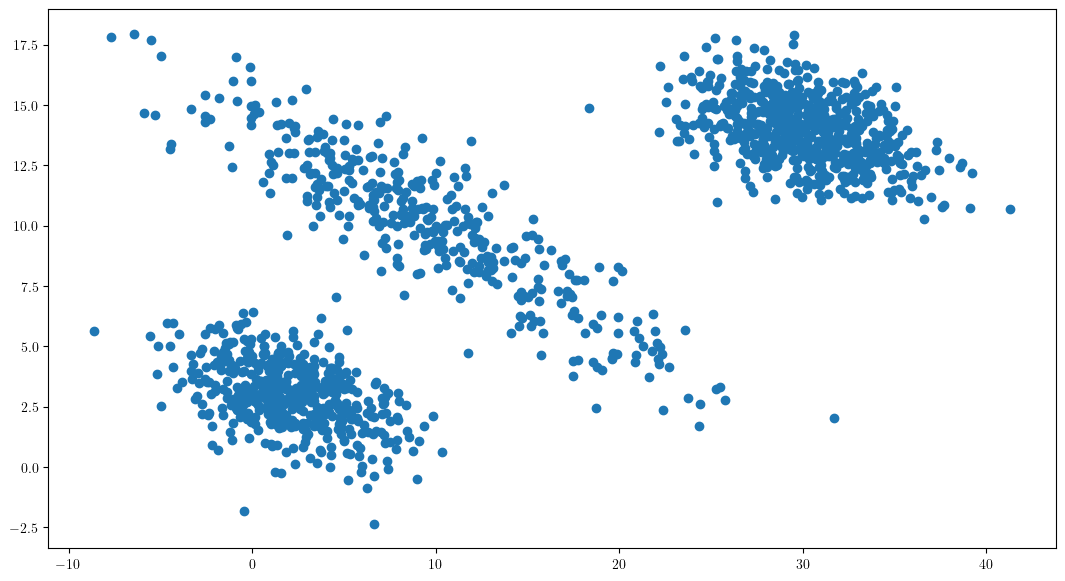

In [12]:
plt.scatter(X[:, 0], X[:, 1])

In [10]:
X.shape

(1000,)